In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from datetime import datetime
import pandas_datareader as pdr
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

In [2]:
yf.pdr_override()
# Fetching the data
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
df = df['Close'].values.reshape(-1, 1)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

# Splitting into training and test sets
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

# Creating sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Length of the input sequence
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshaping input to fit the CNN-LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [4]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))

# Compiling and fitting the model
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32)


Epoch 1/20
72/72 [==============================] - 4s 8ms/step - loss: 0.0046
Epoch 2/20
72/72 [==============================] - 1s 8ms/step - loss: 6.3113e-04
Epoch 3/20
72/72 [==============================] - 1s 8ms/step - loss: 4.7934e-04
Epoch 4/20
72/72 [==============================] - 1s 8ms/step - loss: 4.8566e-04
Epoch 5/20
72/72 [==============================] - 1s 10ms/step - loss: 5.7207e-04
Epoch 6/20
72/72 [==============================] - 1s 14ms/step - loss: 7.0690e-04
Epoch 7/20
72/72 [==============================] - 1s 16ms/step - loss: 4.3314e-04
Epoch 8/20
72/72 [==============================] - 1s 16ms/step - loss: 4.0708e-04
Epoch 9/20
72/72 [==============================] - 1s 17ms/step - loss: 4.6308e-04
Epoch 10/20
72/72 [==============================] - 1s 20ms/step - loss: 4.4003e-04
Epoch 11/20
72/72 [==============================] - 2s 22ms/step - loss: 3.6287e-04
Epoch 12/20
72/72 [==============================] - 1s 15ms/step - loss: 4.0083e-

In [5]:
# Predicting on the test set
predictions = model.predict(X_test)

# Inverse scaling for predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)
# Evaluating the model
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)

18/18 [==============================] - 1s 3ms/step
Root Mean Squared Error (RMSE): 9.634991172100541


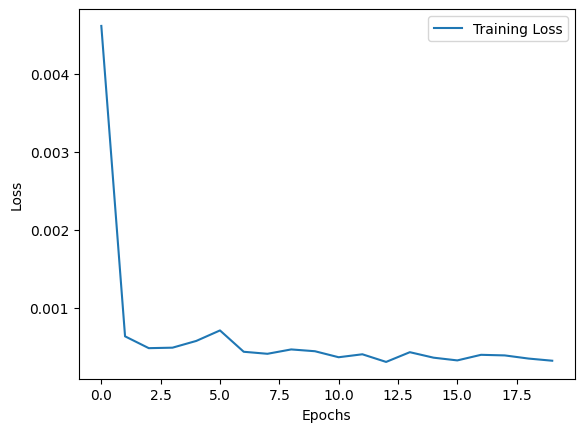

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             256       
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 64)             12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm (LSTM)                 (None, 3, 100)            66000     
                                                                 
 dropout_1 (Dropout)         (None, 3, 100)            0         
                                                        

In [8]:
import numpy as np
stock_prediction = np.array(predictions)
y_test = np.array(y_test)
ape = np.abs(y_test - stock_prediction) / np.abs(y_test)
mape = np.mean(ape) * 100
accuracy = 100 - mape
print("The CNN LSTM's accuracy in predicting the stock price is: " + str(accuracy) + "%")

The CNN LSTM's accuracy in predicting the stock price is: 94.97507603518504%


In [9]:
import numpy as np

predictions = np.array(predictions)

# Extrapolate the maximum and minimum values
maxValTest = round(float(np.max(y_test)), 2)
minValTest = round(float(np.min(y_test)), 2)
print("The real maximum stock price is: " + str(maxValTest) + " dollars")
print("The real minimum stock price is: " + str(minValTest) + " dollars")

The real maximum stock price is: 186.01 dollars
The real minimum stock price is: 119.9 dollars


In [10]:
maxValPredict = round(float(max(predictions)), 2)
minValPredict = round(float(min(predictions)), 2)
print ("The predicted maximum stock price is: " + str(maxValPredict) +" dollars")
print ("The predicted minimum stock price is: " + str(minValPredict) +" dollars")

The predicted maximum stock price is: 164.2 dollars
The predicted minimum stock price is: 121.47 dollars


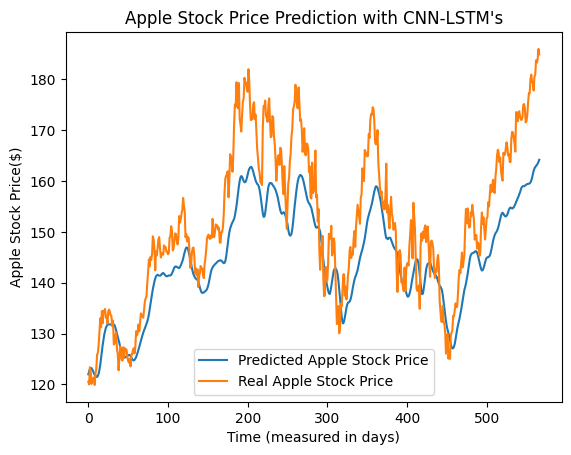

In [11]:
#Graph the real stock prices against the model's prediction
plt.plot(predictions, label = 'Predicted Apple Stock Price', linewidth = 1.5)
plt.plot(y_test, label = 'Real Apple Stock Price', linewidth = 1.5)
plt.title("Apple Stock Price Prediction with CNN-LSTM's")
plt.xlabel('Time (measured in days)')
plt.ylabel('Apple Stock Price($)')
plt.legend()
plt.show()

In [12]:
import tensorflow as tf
model.save("mat_model2.h5")

In [13]:
original  = pdr.get_data_yahoo('AAPL', start='2023-05-26', end='2023-05-28')
original

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-26,173.320007,175.770004,173.110001,175.429993,175.429993,54835000
